In [25]:
%run func_def.ipynb

imports loaded.

> Pre-Processing func:
    get_height(item)
    get_weight(item)
    get_reach(item)
    get_std_reach(item, height, reach_list, height_list)
    get_age(item)
    get_std_age(item, age_list)
    get_win_prob(name, date, df)
    get_win_streak(name, date, df) #return count of recent wins
    get_lose_streak(name, date, df)
    get_fighter_stats(name, data )

> Feature Engineering func:
    get_stat(index, data, stat='height', fo='')
    get_swaped_row(index, data) # return fighter & opponent statistics swapped. 
    get_wins(combo, data)
    get_wins_ratio(combo, data)

> outlier_cleaning func:
    set_outlier_detection_model(X_columns, data)

> model_stats_pred_training func:
    set_lower_cases(string)
    set_train_test(X_columns, y_columns, data, test_size=0.3, valid_size=0.3)
    set_xgboost_reg(X_columns, y_columns, data, n=200, learning_rate=0.2, subsample=0.4, max_depth=5)
    set_predictions(model, data, X_columns, y_columns)
    get_mean_percentage_error(act,

SyntaxError: invalid syntax (<ipython-input-25-d960544c3de0>, line 1)

### <span style='color:green'> **[done]** </span>Loading stats & results trained data:

In [18]:
df = pd.read_csv('../data/data_result_prediction_set.csv')
df.tail(3)

,set,date,weight_class,fighter,opponent,method,outlier,lof_outlier,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,result,result_pred
919,train,1997-05-30,Lightweight,Tito Ortiz,Guy Mezger,SUB,False,False,-0.001919,0.191761,0.415429,-0.858406,1.175475,-1.182830,0.6,0.199901,1.174654,0.958556,-1.035152,0.011599,-2.467856,-1.111545,0.00823,lose,lose
920,validation,1997-02-07,Lightweight,Nick Sanzo,Jerry Bohlander,SUB,False,False,-0.001919,-0.066037,-0.369809,-0.858406,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,-1.651041,-0.554406,0.00823,lose,lose
921,validation,1997-02-07,Lightweight,Jerry Bohlander,Rainy Martinez,SUB,False,False,-0.001919,0.007620,0.415429,0.857591,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,1.665719,0.559874,0.00823,win,win


#### <span style='color:green'> **[done]** </span>Filter by weight_class:

In [19]:
weight = "Lightweight"
weight_classes = {'Flyweight':0,'Bantamweight':1,'Featherweight':2,
                  'Lightweight':3,'Welterweight':4,'Middleweight':5,
                  'Light Heavyweight':6,'Heavyweight':7,'Super Heavyweight':8,'Open Weight':9,
                  "Women's Strawweight":10,"Women's Flyweight":11,"Women's Bantamweight":12,
                  "Women's Featherweight":13}

df = df[df['weight_class']==weight].reset_index(drop=True)
df.tail(3)

,set,date,weight_class,fighter,opponent,method,outlier,lof_outlier,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,result,result_pred
919,train,1997-05-30,Lightweight,Tito Ortiz,Guy Mezger,SUB,False,False,-0.001919,0.191761,0.415429,-0.858406,1.175475,-1.182830,0.6,0.199901,1.174654,0.958556,-1.035152,0.011599,-2.467856,-1.111545,0.00823,lose,lose
920,validation,1997-02-07,Lightweight,Nick Sanzo,Jerry Bohlander,SUB,False,False,-0.001919,-0.066037,-0.369809,-0.858406,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,-1.651041,-0.554406,0.00823,lose,lose
921,validation,1997-02-07,Lightweight,Jerry Bohlander,Rainy Martinez,SUB,False,False,-0.001919,0.007620,0.415429,0.857591,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,1.665719,0.559874,0.00823,win,win


### <span style='color:green'> **[done]** </span>Define X & Y:

In [20]:
req_data = ['set','date','weight_class','fighter','opponent']
y = ['method']
X = ['result','kd_dif','str_dif','td_dif','sub_dif',
    'td_avg_dif','td_def_dif','sub_avg_dif',
    'slpm_dif','str_acc_dif','sapm_dif','str_def_dif',
    'stance_win_ratio','win_perc_dif','win_strk_dif','lose_strk_dif'
    ]

df = df[req_data + X + y]
df.tail(3)

,set,date,weight_class,fighter,opponent,result,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,method
919,train,1997-05-30,Lightweight,Tito Ortiz,Guy Mezger,lose,-0.001919,0.191761,0.415429,-0.858406,1.175475,-1.182830,0.6,0.199901,1.174654,0.958556,-1.035152,0.011599,-2.467856,-1.111545,0.00823,SUB
920,validation,1997-02-07,Lightweight,Nick Sanzo,Jerry Bohlander,lose,-0.001919,-0.066037,-0.369809,-0.858406,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,-1.651041,-0.554406,0.00823,SUB
921,validation,1997-02-07,Lightweight,Jerry Bohlander,Rainy Martinez,win,-0.001919,0.007620,0.415429,0.857591,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,1.665719,0.559874,0.00823,SUB


### <span style='color:green'> **[done]** </span>Feature relevant methods only

In [21]:
for i in tqdm(range(0,len(df))):
    
    method = str(df.loc[i,'method'])
    
    if method.find('KO/TKO') != -1:
        df.loc[i,'method'] = 'knockout'
    elif method.find('DEC') != -1:
        df.loc[i,'method'] = 'decision'
    elif method.find('SUB') != -1:
        df.loc[i,'method'] = 'submission'
    elif method.find('DQ') != -1:
        df.loc[i,'method'] = 'disqual'

df = df[df.method != 'disqual'].reset_index(drop=True)         
df.method.unique() 

100%|██████████| 922/922 [00:00<00:00, 6001.51it/s]


array(['decision', 'knockout', 'submission'], dtype=object)

### <span style='color:green'> **[done]** </span>Transform Categorical feature "result" to fit classifier model:

In [22]:
for i in tqdm(range(len(df))):
    fighter = df.loc[i,'fighter']
    result = df.loc[i,'result']
    df.loc[i,'result'] = len(df[(df.result==result)&(df.fighter==fighter)])/len(df[df.fighter==fighter])

df.tail(3)

100%|██████████| 920/920 [00:00<00:00, 1199.86it/s]


,set,date,weight_class,fighter,opponent,result,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,method
917,train,1997-05-30,Lightweight,Tito Ortiz,Guy Mezger,1.0,-0.001919,0.191761,0.415429,-0.858406,1.175475,-1.182830,0.6,0.199901,1.174654,0.958556,-1.035152,0.011599,-2.467856,-1.111545,0.00823,submission
918,validation,1997-02-07,Lightweight,Nick Sanzo,Jerry Bohlander,1.0,-0.001919,-0.066037,-0.369809,-0.858406,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,-1.651041,-0.554406,0.00823,submission
919,validation,1997-02-07,Lightweight,Jerry Bohlander,Rainy Martinez,1.0,-0.001919,0.007620,0.415429,0.857591,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,1.665719,0.559874,0.00823,submission


### <span style='color:green'> **[done]** </span>Logistic regression model training:

In [23]:
logistic_reg_clf = set_logistic_reg_clf(X_columns=X, y_columns=y, data=df, penalty='l2', c=1, solver='lbfgs')
df = set_predictions(data=df,model=logistic_reg_clf, X_columns=X, y_columns=y)
df.tail(3)

,set,date,weight_class,fighter,opponent,result,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,method,method_pred
917,train,1997-05-30,Lightweight,Tito Ortiz,Guy Mezger,1.0,-0.001919,0.191761,0.415429,-0.858406,1.175475,-1.182830,0.6,0.199901,1.174654,0.958556,-1.035152,0.011599,-2.467856,-1.111545,0.00823,submission,submission
918,validation,1997-02-07,Lightweight,Nick Sanzo,Jerry Bohlander,1.0,-0.001919,-0.066037,-0.369809,-0.858406,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,-1.651041,-0.554406,0.00823,submission,decision
919,validation,1997-02-07,Lightweight,Jerry Bohlander,Rainy Martinez,1.0,-0.001919,0.007620,0.415429,0.857591,0.009779,-0.004909,0.0,0.017435,0.019013,-0.002630,0.007469,0.011599,1.665719,0.559874,0.00823,submission,decision


Accuracy = 0.450909


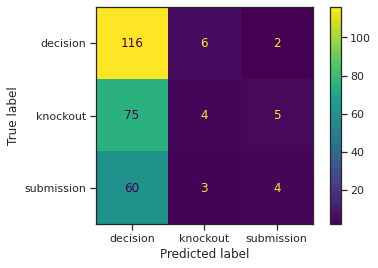

In [26]:
get_model_evaluation(data=df,y_column='method')

### <span style='color:green'> **[done]** </span>Gridsearch - Parameter Tuning:

In [28]:
train_index = df.index[df.set=='train']
valid_index = df.index[df.set=='validation']

grid = {'C':[],
       'train_accuracy':[],
       'valid_accuracy':[],
       }

for c in tqdm([0.01,0.025,0.05,0.065,0.75,0.1,0.15,1]):
    grid['C'].append(c)
    logistic_reg_clf = set_logistic_reg_clf(X_columns=X, y_columns=y, data=df, penalty='l2', c=c, solver='lbfgs')
    df = set_predictions(data=df,model=logistic_reg_clf, X_columns=X, y_columns=y)
    grid['train_accuracy'].append(get_accuracy(act=df.loc[train_index,'method'], pred=df.loc[train_index,'method_pred']))
    grid['valid_accuracy'].append(get_accuracy(act=df.loc[valid_index,'method'], pred=df.loc[valid_index,'method_pred']))
    
grid = grid = pd.DataFrame(data=grid)
grid

100%|██████████| 8/8 [00:00<00:00, 80.11it/s]


,C,train_accuracy,valid_accuracy
0,0.010,0.529801,0.494792
1,0.025,0.536424,0.489583
2,0.050,0.538631,0.484375
3,0.065,0.536424,0.479167
4,0.750,0.540839,0.463542
5,0.100,0.540839,0.479167
6,0.150,0.543046,0.463542
7,1.000,0.540839,0.463542


Text(0, 0.5, 'Accuracy')

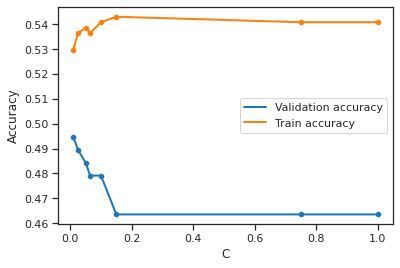

In [29]:
sns.lineplot( data=grid, x='C', y='valid_accuracy', label='Validation accuracy')
sns.scatterplot( data=grid, x='C', y='valid_accuracy')
sns.lineplot( data=grid, x='C', y='train_accuracy', label='Train accuracy')
sns.scatterplot( data=grid, x='C', y='train_accuracy')
plt.ylabel("Accuracy")

In [31]:
best_model_param = grid.sort_values(by=['valid_accuracy','C'], ascending=False).reset_index(drop=True)
best_c = best_model_param.iloc[0]['C']
best_model_param.iloc[0]

C                 0.010000
train_accuracy    0.529801
valid_accuracy    0.494792
Name: 0, dtype: float64

### <span style='color:green'> **[done]** </span>Train model with best parameters & 10-fold Cross-Validation:

In [32]:
k = 10
size = len(df)
batch = int(size/k)
acc = []

for i in tqdm(range(0,size-batch,batch)):
    test_start = i
    test_end = i + batch - 1
    df.loc[:,'set'] = 'train'
    df.loc[test_start:test_end,'set'] = 'test'
    rf_clf = set_logistic_reg_clf(X_columns=X, y_columns=y, data=df, penalty='l2', c=best_c, solver='lbfgs')
    df = set_predictions(model=rf_clf, data=df, X_columns=X, y_columns=y) 
    y_test_act = df['method'][df.set=='test']
    y_test_pred = df['method_pred'][df.set=='test']
    print(get_accuracy(act=y_test_act, pred=y_test_pred))

opt_acc = np.mean(acc)    
print('%d-Fold cross-validation model accuracy: %.4f' %(k,opt_acc))

100%|██████████| 9/9 [00:00<00:00, 61.14it/s]

0.43478260869565216
0.5434782608695652
0.4673913043478261
0.5434782608695652
0.5108695652173914
0.4782608695652174
0.5760869565217391
0.44565217391304346
0.532608695652174
10-Fold cross-validation model accuracy: nan



/homes/sagic/.conda/envs/py3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/homes/sagic/.conda/envs/py3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
